### Test Model 1 - Using spectral images to classify speech command
### Tested on only 5 speech commands

### Imports 

In [538]:
import os

#Data Handling
import pandas as pd
import numpy as np

#Spectral image generation
from librosa import power_to_db
from librosa import load
from librosa.feature import melspectrogram 
from librosa.display import specshow

#Image Processing 
import cv2

#Machine & Deep Learning
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense
from keras.models import Sequential, Model

#Visualizations
import matplotlib.pyplot as plt
import warnings

#Manual testing packages
import sounddevice as sd
from scipy.io.wavfile import write

warnings.filterwarnings("ignore")

### Create spectral images from the input audio files

In [31]:
def create_spectrogram(filename,savepath):
    clip, sample_rate = load(filename, sr=None)
    plt.interactive(False)
    fig = plt.figure(figsize=[2.0,2.0])
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    S = melspectrogram(y=clip, sr=sample_rate)
    specshow(power_to_db(S, ref=np.max),x_axis='time', y_axis='hz')
    plt.savefig(savepath, dpi=1200, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,savepath,clip,sample_rate,fig,ax,S

In [96]:
def create_images(rootdir,savedir):
    i = 0 
    for i, (subdirs, dirs, files) in enumerate(os.walk(rootdir)):
        for file in files:
            if not file.startswith('.'):
                fname,_ = file.split('.')
                folder = subdirs.split('/')[-1]
                create_spectrogram(os.path.join(subdirs,file),savedir+folder+'/'+fname+'.jpg')          
        

In [510]:
#### DO NOT RUN THESE CELLS IF SPECTRAL IMAGES HAVE BEEN CREATED ###
#rootdir = '/Users/sahityasridhar/Documents/OS/dataset/audio/'
#savedir = '/Users/sahityasridhar/Documents/OS/dataset/images/'
#create_images(rootdir,savedir)
####################################################################

### Load spectral images into arrays

In [476]:
def create_dataset(directory):
    X = []
    Y = [] 
    for i, (subdirs, dirs, files) in enumerate(os.walk(directory)):
        for file in files:
            if not file.startswith('.'):
                label = subdirs.split('/')[-1]
                image = cv2.imread(os.path.join(subdirs,file),0)
                image = cv2.resize(image,(64,64))
                X.append(image)
                Y.append(label)
    return np.array(X),np.array(Y)

In [477]:
X,Y = create_dataset(savedir)

In [478]:
X.shape

(160, 64, 64)

In [479]:
X = X/255.0

In [480]:
X.shape,Y.shape

((160, 64, 64), (160,))

### One Hot Encode the output

In [483]:
le = LabelEncoder()
Y = le.fit_transform(Y)
NUM_CLASSES = len(le.classes_)
Y = np.eye(NUM_CLASSES)[Y]

### Train test split

In [484]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,stratify=Y)

In [485]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((112, 64, 64), (48, 64, 64), (112, 6), (48, 6))

In [486]:
X_train = X_train.reshape(112,64*64)
X_test = X_test.reshape(48,64*64)

###  Image Classification Model

In [487]:
from keras.layers import Dense
from keras.models import Sequential, Model

In [530]:
model = Sequential()

model.add(Dense(1024, input_shape=(4096,), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [531]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_127 (Dense)            (None, 1024)              4195328   
_________________________________________________________________
dense_128 (Dense)            (None, 256)               262400    
_________________________________________________________________
dense_129 (Dense)            (None, 64)                16448     
_________________________________________________________________
dense_130 (Dense)            (None, 6)                 390       
Total params: 4,474,566
Trainable params: 4,474,566
Non-trainable params: 0
_________________________________________________________________


In [532]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [533]:
history = model.fit(X_train,y_train,batch_size=8,epochs=75,validation_split=0.2)

Train on 89 samples, validate on 23 samples
Epoch 1/75
89/89 [==============================] - 5s 52ms/step - loss: 1.4458 - acc: 0.4382 - val_loss: 1.4551 - val_acc: 0.3913
Epoch 2/75
89/89 [==============================] - 1s 10ms/step - loss: 0.9204 - acc: 0.7079 - val_loss: 1.1399 - val_acc: 0.5652
Epoch 3/75
89/89 [==============================] - 1s 10ms/step - loss: 0.3467 - acc: 0.8764 - val_loss: 0.7189 - val_acc: 0.7391
Epoch 4/75
89/89 [==============================] - 1s 10ms/step - loss: 0.3272 - acc: 0.8876 - val_loss: 0.4511 - val_acc: 0.8696
Epoch 5/75
89/89 [==============================] - 1s 10ms/step - loss: 0.1450 - acc: 0.9775 - val_loss: 0.3254 - val_acc: 0.8696
Epoch 6/75
89/89 [==============================] - 1s 10ms/step - loss: 0.2743 - acc: 0.8989 - val_loss: 0.4187 - val_acc: 0.7826
Epoch 7/75
89/89 [==============================] - 1s 10ms/step - loss: 0.0617 - acc: 0.9775 - val_loss: 0.0940 - val_acc: 0.9565
Epoch 8/75
89/89 [=====================

### Plot Validation and Training Loss curves

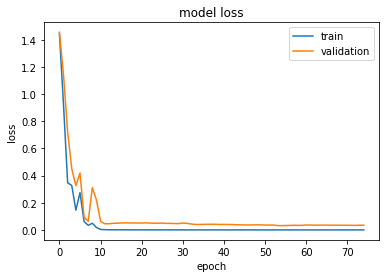

In [534]:
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Test Data Accuracy 

In [535]:
model.evaluate(X_test,y_test)

48/48 [==============================] - 0s 593us/step


[0.42624523242314655, 0.9166666666666666]

In [536]:
model.evaluate(X_train,y_train)

112/112 [==============================] - 0s 694us/step


[0.007131736523920803, 1.0]

In [537]:
model.save('V1AudioClassification')

### Manual Tests

#### Record and create audio file

In [635]:
fs = 44100  # this is the frequency sampling; also: 4999, 64000
seconds = 2  # Duration of recording
 
myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
print("Starting: Speak now!")
sd.wait()  # Wait until recording is finished
print("finished")
write('output.mp3', fs, myrecording)  # Save as WAV file

Starting: Speak now!
finished


#### Convert audio file to corresponding spectral images

In [636]:
clip, sample_rate = load('/Users/sahityasridhar/Documents/OS/output.mp3', sr=None)
plt.interactive(False)
fig = plt.figure(figsize=[2.0,2.0])
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
S = melspectrogram(y=clip, sr=sample_rate)
specshow(power_to_db(S, ref=np.max),x_axis='time', y_axis='hz')
plt.savefig('/Users/sahityasridhar/Documents/OS/output.jpg', dpi=1200, bbox_inches='tight',pad_inches=0)
plt.close()    
fig.clf()
plt.close(fig)
plt.close('all')
os.remove('/Users/sahityasridhar/Documents/OS/output.mp3')
del clip,sample_rate,fig,ax,S

#### Image preprocessing 

In [637]:
image = cv2.imread('/Users/sahityasridhar/Documents/OS/output.jpg',0)
sample = cv2.resize(image,(64,64))
sample = sample/255.0
sample = sample.reshape(1,64*64)
os.remove('/Users/sahityasridhar/Documents/OS/output.jpg')

In [638]:
sample.shape

(1, 4096)

#### Retrieve predictions

In [639]:
result = model.predict_classes(sample)

In [640]:
print(result,le.classes_[result])

[2] ['join']
